In [8]:
import deblend
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")

In [9]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


In [10]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [11]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1908
Number of these with 4 images =  276
Number of these with i3 < 22 =  116


# Three different ways of implementation

All the versions --- 1, 2, and 3 --- agreed on the zeroth and the first moment.

For version 1(code that I wrote + stackExchange), it just implements the algorithm using the definition of the zeroth, first, and the second moment. It does give reasonable values, but it only divides the value of calculated 2nd moments($I_{xx}$, $I_{yy}$, $I_{xy}$) with the zeroth moment once. 

For version 2($skimage.measure.moments$), it gives out ($I_{xx}$, $I_{yy}$, $I_{xy}$). I divided by zeroth moment sqaure. The shape and intensity values are a little odd. 

For version 3(code that I wrote + $scipy.stats.moment$), $scipy.stats.moment$ does array.ravel() (squeeze 2d array into 1d) and calculate the standard deviation for the whole array. This is not what we want.

OM10: Extracted OM10 lens number 75829106:
 LENSID  FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
-------- -------- ---- ----- ... ------------- ------------- -------------
75829106        0    4 1.556 ...         22.25 22.1062472365 23.3006804149
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  2.11635845628e-08
2.8929763793e-08
41.0326355788
0.0202083869461
1520679.98104
#####################BEFORE DEBLEND PLOT LENSES##################################


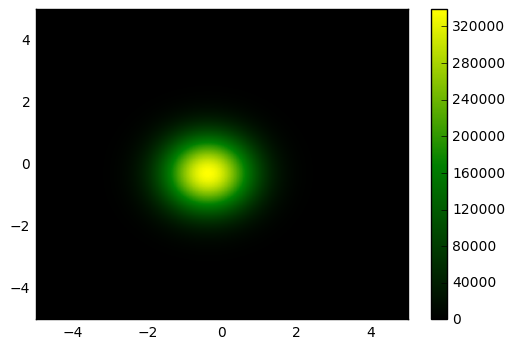

This is the covariance I calculated:  [[  7.14832561e+03   7.76251695e-02]
 [  7.76251695e-02   7.14846916e+03]]
This is the eigenvalue I have (array([ 7148.2916646 ,  7148.50310909]), array([[-0.91621324,  0.40069103],
       [ 0.40069103,  0.91621324]]))
standard deviation is:  84.547570424
standard deviation is:  84.5488208616


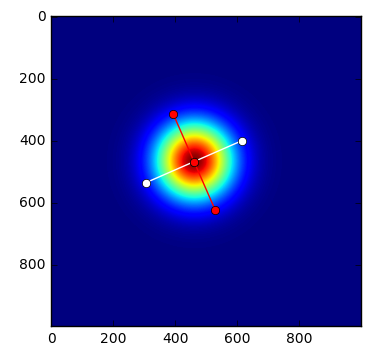

**************zeroth moment:  15207209731.3
**************first moment:  -0.392990260466 -0.321878135672
**************second moment:  [[  7.14832561e+03   7.76251695e-02]
 [  7.76251695e-02   7.14846916e+03]]
#####################PRINTING NULL DEBLENDER'S PLOT###############################


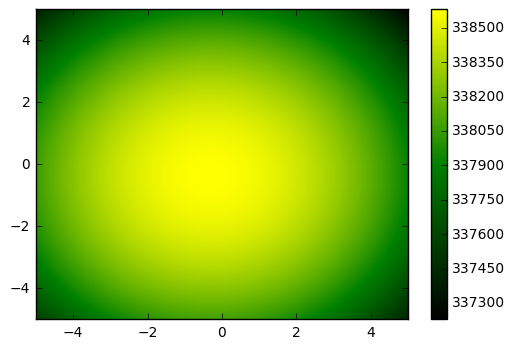

###############################################################################
('chi squared: ', 5.4143851932703894e-05, 'p: ', 1.0)
('Chi squared distance is : ', (5.4143851932703894e-05, 1.0))
('KL distance is : ', 8.722886390290963)


In [12]:
realizer.deblend(lensID=k, version=1, null_deblend=True, debug=True, show_plot=True)

OM10: Extracted OM10 lens number 75829106:
 LENSID  FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
-------- -------- ---- ----- ... ------------- ------------- -------------
75829106        0    4 1.556 ...         22.25 22.1062472365 23.3006804149
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  7.45978482405e-08
2.8929763793e-08
41.0326355788
0.0202083869461
1520679.98104
#####################BEFORE DEBLEND PLOT LENSES##################################


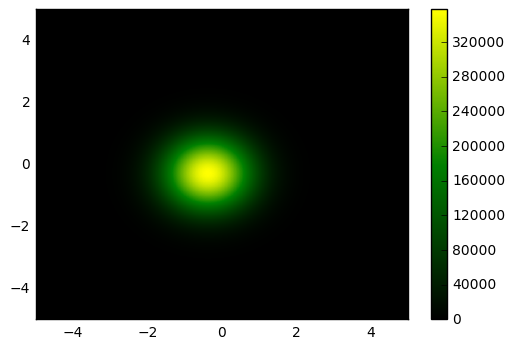

**************zeroth moment:  15207210085.6
**************first moment:  -0.392990327595 -0.321878178373
**************second moment:  [[ 0.68179616 -0.00504918]
 [-0.00504918  0.68178191]]
#####################PRINTING NULL DEBLENDER'S PLOT###############################


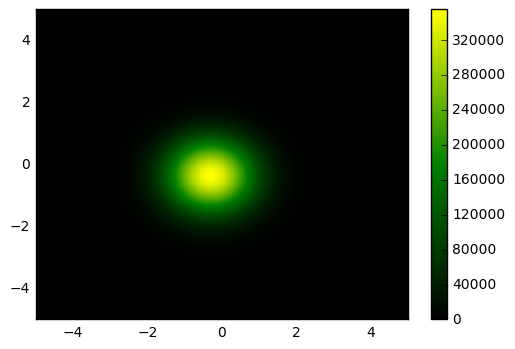

In [13]:
realizer.deblend(lensID=k, version=2, null_deblend=True, debug=True, show_plot=True, report_distance=False)

OM10: Extracted OM10 lens number 75829106:
 LENSID  FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
-------- -------- ---- ----- ... ------------- ------------- -------------
75829106        0    4 1.556 ...         22.25 22.1062472365 23.3006804149
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  7.45978482405e-08
2.8929763793e-08
41.0326355788
0.0202083869461
1520679.98104
#####################BEFORE DEBLEND PLOT LENSES##################################


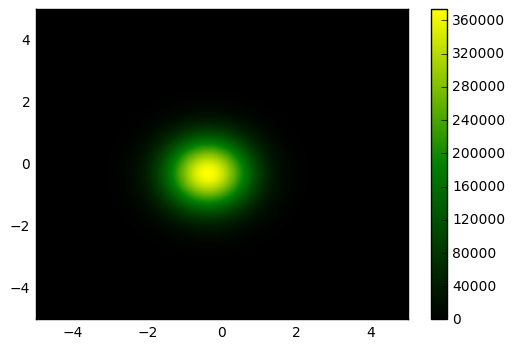

**************zeroth moment:  15207210214.6
**************first moment:  -0.321878193729 -0.392990352288
**************second moment:  2606258848.5
#####################PRINTING NULL DEBLENDER'S PLOT###############################


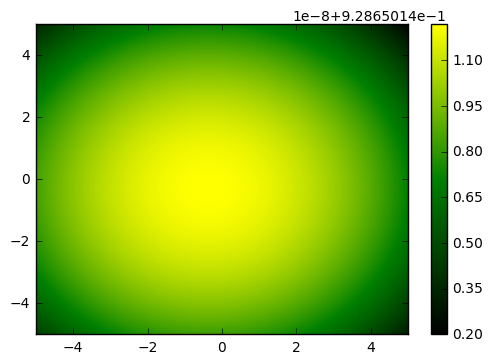

In [14]:
realizer.deblend(lensID=k, version=3, null_deblend=True, debug=True, show_plot=True, report_distance=False)